In [1]:
# Utility
import numpy as np
import yaml

# ALPaCA code
from main.alpaca import *
from main.dataset import *
from main.dataViz import *

# Mountain Car related
from MCTransfer import MountainCarTransfer as MCF
from MCWrapper import play_episode
from VIAgent import MCVI
from MCDataset import MCOnlineSampleDataset, MCOfflineDataset
from ALPaCAQ_agent import ALPaCA_Q

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm

# MAML
#from main.maml_agent import MAMLAgent, register_flags
#register_flags()

/home/jack/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [2]:
%reload_ext autoreload
%autoreload 2

## Offline ALPaCA Training / Load Pretrained ALPaCA

In [3]:
# Load data set
cfg_filename = 'MC-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)
dataset = MCOfflineDataset(config)

In [4]:
# Initialize agent
g1 = tf.Graph()
sess1 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g1)
agent = ALPaCA(config, sess1, g1)
agent.construct_model()

In [5]:
# Either load pre-trained agent
agent.restore('./Pretrained_alpaca/norm_y_2/')
# Or train agent and save
#agent.train(dataset,2000)
#agent.save('./Pretrained_alpaca/norm_y_2//')

INFO:tensorflow:Restoring parameters from ./Pretrained_alpaca/norm_y_2/
Restored model from: ./Pretrained_alpaca/norm_y_2/


## Online prediction with analytical solution

In [ ]:
# Extract information from agent
K0 = sess1.run(agent.K)
L0 = sess1.run(agent.L)
L0_inv = np.linalg.inv(L0)
Sig = sess1.run(agent.SigEps)
encode = agent.encode

In [ ]:
# Predict a specific point
state = np.array([0.5, 0.06])
norm_ob = dataset.normalize_x(state[None,None,:])
phi = encode(norm_ob)[0].T
pred_mean = dataset.denormalize_y(K0.T @ phi)
pred_var = (1 + phi.T @ L0_inv @ phi) * np.diag(Sig[0,0]) * (dataset.q_var ** 2)
pred_mean.flatten(), pred_var

In [ ]:
# Update the model with some test online data
# Suppose online data is: (for action 0)
# - (0.5,0.06) --> 1
action = 0
X = np.array([[0.5,0.06]]).T
Y = np.array([[0]])
# Preprocess the data
norm_X = dataset.normalize_x(X.T[None,:,:])
Phi = agent.encode(norm_X)[0].astype(np.float64)
norm_Y = dataset.normalize_y(Y[None,:,:])

In [ ]:
# Predict the same point after the observations using the analytical solution
L_ana = (Phi.T @ Phi + L0).astype(np.float64)
L_ana_inv = np.linalg.inv(L_ana)
K_ana = K0.copy().astype(np.float64)
Q_ana = Phi.T @ norm_Y + (L0 @ (K0[:, action]))[:, None]
K_ana[:, action] = (L_ana_inv @ Q_ana)[0,:,0]
pred_mean = dataset.denormalize_y(K_ana.T @ phi)
pred_var = (1 + phi.T @ L_ana_inv @ phi) * np.diag(Sig[0,0]) * (dataset.q_var ** 2)
pred_mean.flatten(), pred_var

## Online prediction with incremental update

In [ ]:
# Predict the same point after incremental update
aq = ALPaCA_Q(agent, None, config, sess1)

In [ ]:
aq.update_model(X.T[0],action,norm_Y[0])
target = dataset.normalize_y(0)
aq.predict_q_values(state).flatten()

In [ ]:
aq.predict_var(state) * dataset.q_var ** 2

## Plot true q-table

In [ ]:
def sample_MC_parameters(config):
    """
    Sample a gravity - thrust file that is compatible with the config file
    """
    # Sample a thrust-gravity pair
    thrust_range = config['thrust_range']
    gravity_range = config['gravity_range']
    thrust_diff = thrust_range[1] - thrust_range[0]
    grav_diff = gravity_range[1] - gravity_range[0]
    thrust = np.random.random() * thrust_diff + thrust_range[0]
    grav = np.random.random() * grav_diff + gravity_range[0]
    return grav, thrust

In [ ]:
def plot_true_cost_to_go(Q_table, savedir=None):
    """
    Plots the cost_to_go for a given Q-table as a 3-d surface map
    Assumes Q_table is of shape (N,N,3)
    """
    assert len(Q_table.shape) == 3 and Q_table.shape[0] == Q_table.shape[1]
    gran = Q_table.shape[0]
    X = np.arange(-1.2, 0.6, 1.8/gran)
    Y = np.arange(-0.07, 0.07, 0.14/gran)
    X,Y = np.meshgrid(x_sample,y_sample)
    Z = Q_table.max(axis=2).T
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,-state_value.T, rstride=5, cstride=5, cmap=cm.coolwarm)
    if savedir is not None:
        fig.savefig(savedir,transparent=True)

In [ ]:
# Sample or specify a gravity - thrust pair
gravity, thrust = 0.0025, 0.001

In [ ]:
# Compute VI for this configuration
gran = 150
VIagent = MCVI(gran, 200, gravity=grav, thrust=thrust)
VIagent.value_iteration()
Q_table = VIagent.q_table

In [ ]:
# Plot
plot_true_cost_to_go(Q_table)

## Plot learned q function

In [7]:
def plot_learned_cost_to_go(ALPaCA_Q, grid, savedir=None):
    """
    Plot the learned cost to go function for an ALPaCA_Q agent
    """
    # Process the data for plotting
    X = np.arange(-1.2, 0.6, 1.8/grid)
    Y = np.arange(-0.07, 0.07, 0.14/grid)
    X,Y = np.meshgrid(X,Y)
    # Fill in the table by iteratively querying the agent
    Z = np.zeros(X.shape)
    for i in range(grid):
        for j in range(grid):
            Z[i,j] = ALPaCA_Q.predict_q_values(np.array([X[i,j],Y[i,j]])).max()
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,-Z, cmap=cm.coolwarm)
    if savedir is not None:
        fig.savefig(savedir,transparent=True)

In [8]:
def plot_learned_variance(ALPaCA_Q, grid, savedir=None):
    """
    Plot the learned cost to go function for an ALPaCA_Q agent
    """
    # Process the data for plotting
    X = np.arange(-1.2, 0.6, 1.8/grid)
    Y = np.arange(-0.07, 0.07, 0.14/grid)
    X,Y = np.meshgrid(X,Y)
    # Fill in the table by iteratively querying the agent
    Z = np.zeros(X.shape)
    for i in range(grid):
        for j in range(grid):
            s = np.array([X[i,j],Y[i,j]])
            Z[i,j] = ALPaCA_Q.predict_var(s).mean()
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,np.sqrt(Z), cmap=cm.coolwarm)
    if savedir is not None:
        fig.savefig(savedir,transparent=True)

In [ ]:
# Define an agent
agent.restore('./Pretrained_alpaca/norm_y_2/')
aq = ALPaCA_Q(agent, None, config, sess1)

In [ ]:
plot_learned_cost_to_go(MCaq, 20)

In [ ]:
plot_learned_variance(aq,20)

## Mountain Car Experiment / RL

In [6]:
def plot_summary(result):
    avg_result = result.mean(0)
    ind = np.arange(len(avg_result)) + 1
    plt.plot(ind, avg_result)
    plt.show()

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# Create environment and ALPaCA Q agent
env = MCF()
agent.restore('./Pretrained_alpaca/norm_y_2/')
aq = ALPaCA_Q(agent, None, config, sess1)
MCaq = ALPaCA_Q(agent, env, config, sess1)

In [9]:
grav, thru = (0.0021448523969069813, 0.0012198799893080752)
env1 = MCF(gravity=grav, thrust=thru)
grav, thru = (0.0023464856819864063, 0.0013694856651231633)
env2 = MCF(gravity=grav, thrust=thru)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
# E-greedy learning env1
num_experiments = 20
num_episodes = 10
num_plays = 3
step_limit = 200
env = env1
e_greedy_results_env1 = np.zeros((num_experiments, num_episodes))
# Run experiment
for i in tqdm(range(num_experiments)):
    MCaq = ALPaCA_Q(agent, env, config, sess1) #Reinitialize agent for each experiment
    for j in range(num_episodes):
        train_step = MCaq.e_greedy_train_episode(step_limit,render=False)
        # Play several games to find average steps
        play_step = []
        for k in range(num_plays):
            play_step.append(play_episode(env, MCaq, render=False,it=step_limit))
        e_greedy_results_env1[i][j] = np.mean(play_step)

In [ ]:
# E-greedy learning env2
num_experiments = 20
num_episodes = 1000
num_plays = 3
step_limit = 200
env = env2
e_greedy_results_env2 = np.zeros((num_experiments, num_episodes))
# Run experiment
for i in tqdm(range(num_experiments)):
    MCaq = ALPaCA_Q(agent, env, config, sess1) #Reinitialize agent for each experiment
    for j in range(num_episodes):
        train_step = MCaq.e_greedy_train_episode(step_limit,render=False)
        # Play several games to find average steps
        play_step = []
        for k in range(num_plays):
            play_step.append(play_episode(env, MCaq, render=False,it=step_limit))
        e_greedy_results_env2[i][j] = np.mean(play_step)

In [12]:
# TS learning env1
num_experiments = 10
num_episodes = 1000
num_plays = 3
step_limit = 200
env = env1
# Array to store results
TS_results_env1 = np.zeros((num_experiments, num_episodes))
# Run experiment
for i in tqdm(range(num_experiments)):
    MCaq = ALPaCA_Q(agent, env, config, sess1)
    for j in range(num_episodes):
        train_step = MCaq.ts_train_episode(step_limit,render=False)# Train an episode and get data
        # Play several games to find average steps
        play_step = []
        for k in range(num_plays):
            play_step.append(play_episode(env, MCaq, render=False,it=step_limit))
        TS_results_env1[i][j] = np.mean(play_step)

100%|██████████| 10/10 [1:29:44<00:00, 517.06s/it]


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


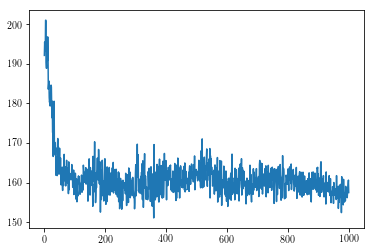

In [13]:
plot_summary(TS_results_env1)

In [ ]:
# TS learning env2
num_experiments = 20
num_episodes = 1000
num_plays = 3
step_limit = 200
env = env2
# Array to store results
TS_results_env2 = np.zeros((num_experiments, num_episodes))
# Run experiment
for i in tqdm(range(num_experiments)):
    MCaq = ALPaCA_Q(agent, env, config, sess1)
    for j in range(num_episodes):
        train_step = MCaq.ts_train_episode(step_limit,render=False)# Train an episode and get data
        # Play several games to find average steps
        play_step = []
        for k in range(num_plays):
            play_step.append(play_episode(env, MCaq, render=False,it=step_limit))
        TS_results_env2[i][j] = np.mean(play_step)

In [ ]:
# Summerize results
eg_result1 = np.loadtxt()

In [ ]:
plot_summary(e_greedy_results_backup_2)

In [ ]:
plot_learned_cost_to_go(MCaq, grid=25)

In [ ]:
plot_learned_variance(MCaq,grid=25)

In [ ]:
e_greedy_summary = e_greedy_results_env2[:18].mean(0)
plt.plot(np.arange(num_episodes)+1, e_greedy_summary)
#plt.savefig('Plots/e-greedy-steps0.png')

In [ ]:
#env1_params_backup
#env2_params_backup
#e_greedy_results_backup_1 #500 episode original env
#e_greedy_results_backup_2 #1000 episode env1, 20 experiments, epsilon=0.3
#e_greedy_results_backup_3 #1000 episode env2, 19 experiment, epsilon=0.3

## Clean up

In [ ]:
env.close()
env1.close()
env2.close()

In [ ]:
sess1.close()